<a href="https://colab.research.google.com/github/mukulsn/Machine-Learning/blob/main/Tensorflow%20Developer%20Certificate/NLP_text_classification_KerasNLP_FNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification Using FNET

**Date Created:** 04/Dec/2023 <br>
**Description:** Text Classification using `keras_nlp.lyers.FNetEncoder` layer <br>

**Resource:** https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/nlp/ipynb/fnet_classification_with_keras_nlp.ipynb#scrollTo=8dYCmsZNC1Cx

## Introduction

In this example, we will demonstrate the ability of FNet to achieve comparable
results with a vanilla Transformer model on the text classification task.
We will be using the IMDb dataset, which is a
collection of movie reviews labelled either positive or negative (sentiment
analysis).

To build the tokenizer, model, etc., we will use components from
[KerasNLP](https://github.com/keras-team/keras-nlp). KerasNLP makes life easier
for people who want to build NLP pipelines! :)

### Model

Transformer-based language models (LMs) such as BERT, RoBERTa, XLNet, etc. have
demonstrated the effectiveness of the self-attention mechanism for computing
rich embeddings for input text. However, the self-attention mechanism is an
expensive operation, with a time complexity of `O(n^2)`, where `n` is the number
of tokens in the input. Hence, there has been an effort to reduce the time
complexity of the self-attention mechanism and improve performance without
sacrificing the quality of results.

In 2020, a paper titled
[FNet: Mixing Tokens with Fourier Transforms](https://arxiv.org/abs/2105.03824)
replaced the self-attention layer in BERT with a simple Fourier Transform layer
for "token mixing". This resulted in comparable accuracy and a speed-up during
training. In particular, a couple of points from the paper stand out:

* The authors claim that FNet is 80% faster than BERT on GPUs and 70% faster on
TPUs. The reason for this speed-up is two-fold: a) the Fourier Transform layer
is unparametrized, it does not have any parameters, and b) the authors use Fast
Fourier Transform (FFT); this reduces the time complexity from `O(n^2)`
(in the case of self-attention) to `O(n log n)`.
* FNet manages to achieve 92-97% of the accuracy of BERT on the GLUE benchmark.

# SEEMS ISSUE WITH GOOGLE COLAB, GPU IS NOT WORKING

This install command worked :)

In [14]:
!pip install keras-nlp keras-core tensorflow-text --no-deps

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.5/584.5 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 87.2 MB/s eta 0:00:00


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [5]:
# !pip install -q --upgrade keras-nlp
# !pip install -q --upgrade keras # Upgrade to keras 3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.1/997.1 kB 14.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.0 which is incompatible.


In [6]:
import tensorflow as tf
def checking_gpu():
  print(tf.__version__)
  print(tf.config.list_physical_devices())
checking_gpu()

2.14.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# writing a code to check gpu is working or not

In [4]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-12-03 21:23:26--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-12-03 21:23:26 (110 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [5]:
# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

In [6]:
# Download data (same as from Kaggle)
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

# Unzip data
unzip_data("nlp_getting_started.zip")

--2023-12-03 21:23:47--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 2607:f8b0:4023:c0d::cf, 2607:f8b0:4023:c06::cf
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.005s  

2023-12-03 21:23:47 (125 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [7]:
# Turn .csv files into pandas DataFrame's
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42) # shuffle with random_state=42 for reproducibility
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [9]:
# splitting dataset
from sklearn.model_selection import train_test_split

# Use tran_test_split to split training datainto training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled['text'].to_numpy(), # to convert into numpy arrays for tensorflow
                                                                            train_df_shuffled['target'].to_numpy(),
                                                                            test_size=0.1, # 10% of validation set
                                                                            random_state=42)

In [10]:
# tokenisation
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization # after TesorFlow 2.6

# Use the default TextVectorization variables
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocab
                                    standardize='lower_and_strip_punctuation', # how to process text
                                    split='whitespace', # how to split tokens
                                    ngrams=None, # create group of n-words?
                                    output_mode='int', # how to map tokens to numbers
                                    output_sequence_length=None) # how long should the output sequence of tokens be?
                                    # pad_to_max_tokens=True) # Not valid if using max_tokens=None

In [11]:
# text vectorizer
max_vocab_length = 10000
max_length = 15

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                 output_mode='int',
                                 output_sequence_length=max_length)

In [12]:
# fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [13]:
# # Example of pretrained embedding with universal sentence encoder - https://tfhub.dev/google/universal-sentence-encoder/4
# import tensorflow_hub as hub
# embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # load Universal Sentence Encoder
# embed_samples = embed([sample_sentence,
#                       "When you call the universal sentence encoder on a sentence, it turns it into numbers."])

# print(embed_samples[0][:50])

NameError: ignored

In [15]:
import tensorflow_hub as hub

In [18]:
max_vocab_length

10000

In [22]:
max_length

15

In [27]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_5_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer='uniform',
                                    #  input_length=max_length,
                                     name='embedding_5')

# Create 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype='string')
x=text_vectorizer(inputs)
x=model_5_embedding(x)
x=layers.Conv1D(filters=32,kernel_size=5,activation='relu')(x)
x=layers.GlobalMaxPool1D()(x)
# x=layers.Dense(64,activation='relu')(x) # optional dense layer
outputs=layers.Dense(1,activation='sigmoid')(x)
model_5=tf.keras.Model(inputs,outputs,name='model_5_Conv1D')

# compile conv1d model
model_5.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
# summary of model
model_5.summary()

Model: "model_5_Conv1D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)         │ (None, 1)                     │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ text_vectorization_1               │ (None, 15)                    │           0 │
│ (TextVectorization)                │                               │             │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ embedding_5 (Embedding)            │ (None, 15, 128)               │   1,280,000 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ conv1d (Conv1D)                    │ (None, 11, 32)                │      20,512 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ global_max_pooling1d               │ (None, 32)                    │           0 │
│ (GlobalMaxPooling1D)               │                               │             │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_1 (Dense)                    │ (None, 1)                     │          33 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 1,300,545 (4.96 MB)

 Trainable params: 1,300,545 (4.96 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences,val_labels),
                              callbacks=[create_tensorboard_callback('model_logs','Conv1D')])

Saving TensorBoard log files to: model_logs/Conv1D/20231203-213313
Epoch 1/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6551 - loss: 0.6295 - val_accuracy: 0.7827 - val_loss: 0.4692
Epoch 2/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8476 - loss: 0.3752 - val_accuracy: 0.7866 - val_loss: 0.4761
Epoch 3/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9091 - loss: 0.2429 - val_accuracy: 0.7850 - val_loss: 0.5328
Epoch 4/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9475 - loss: 0.1573 - val_accuracy: 0.7837 - val_loss: 0.6065
Epoch 5/5
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9669 - loss: 0.1062 - val_accuracy: 0.7784 - val_loss: 0.6630


In [ ]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
    sentence_encoder_layer, # take in sentences and then encode them into an embedding
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
],name='model_6_USE')

# compile model
model_6.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_6.summary()

# ending code

In [15]:
import keras_nlp
import keras
import tensorflow as tf
import os

keras.utils.set_random_seed(42)

Using TensorFlow backend


In [3]:
# define our hyperparameters
BATCH_SIZE=64
EPOCHS=3
MAX_SEQUENCE_LENGTH=512
VOCAB_SIZE=15000

EMBED_DIM=128
INTERMEDIATE_DIM=512

In [4]:
# Loading dataset
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xzf aclImdb_v1.tar.gz

--2023-12-04 18:14:22--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  7.35MB/s    in 12s     

2023-12-04 18:14:34 (6.76 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [5]:
# samples are present in form of text files. lets inspect the structure
print(os.listdir('./aclImdb'))
print(os.listdir('./aclImdb/train'))
print(os.listdir('./aclImdb/test'))

['README', 'train', 'test', 'imdb.vocab', 'imdbEr.txt']
['unsupBow.feat', 'unsup', 'labeledBow.feat', 'pos', 'urls_pos.txt', 'neg', 'urls_neg.txt', 'urls_unsup.txt']
['labeledBow.feat', 'pos', 'urls_pos.txt', 'neg', 'urls_neg.txt']


In [6]:
# deleting unsup folder as it does not have any label
!rm -rf aclImdb/train/unsup

In [7]:
# we'll use the keras.utils.text_dataset_from_directory utility to generate our labelled tf.data.Dataset dataset from text files
train_ds = keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset='training',
    seed=42,
)
val_ds = keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset='validation',
    seed=42
)
test_ds=keras.utils.text_dataset_from_directory('aclImdb/test',batch_size=BATCH_SIZE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [7]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(text_batch.numpy()[i])
    print(label_batch.numpy()[i])


b'An illegal immigrant resists the social support system causing dire consequences for many. Well filmed and acted even though the story is a bit forced, yet the slow pacing really sets off the conclusion. The feeling of being lost in the big city is effectively conveyed. The little person lost in the big society is something to which we can all relate, but I cannot endorse going out of your way to see this movie.'
0
b"To get in touch with the beauty of this film pay close attention to the sound track, not only the music, but the way all sounds help to weave the imagery. How beautifully the opening scene leading to the expulsion of Gino establishes the theme of moral ambiguity! Note the way music introduces the characters as we are led inside Giovanna's marriage. Don't expect to find much here of the political life of Italy in 1943. That's not what this is about. On the other hand, if you are susceptible to the music of images and sounds, you will be led into a word that reaches beyond

In [8]:
# we will now convert the text to lowercase
train_ds = train_ds.map(lambda x,y : (tf.strings.lower(x),y))
val_ds = val_ds.map(lambda x,y:(tf.strings.lower(x),y))
test_ds = test_ds.map(lambda x,y:(tf.strings.lower(x),y))


In [9]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(text_batch.numpy()[i])
    print(label_batch.numpy()[i])


b"nobody said movies had to be realistic did they? i really liked this movie because i remember when i first saw it in junior high. for all the kids who remember the pmrc and albums before there were warning stickers, it's a cool story for all those kids who were part of the mid to late 80's headbanger crowd."
1
b"a different look at horror. the styling differences between american and russian films is interesting. however from my american perspective this movie just wasn't that good. the protagonist, marie played by anastasia hille wasn't a pleasant character and i had a hard time identifying with her. she was disagreeable most of the time and confused for much of what little time was left. also too much time was spent in bringing her to the main location of the film. then a long time passed before any real suspense built up. once that happened it seemed volume was used as the main effect which was more annoying than anything else. the concept was more original than most direct-to-vid

In [10]:
# tokenizing data
def train_word_pieces(ds,vocab_size,reserved_tokens):
  word_piece_ds = ds.unbatch().map(lambda x,y : x)
  vocab = keras_nlp.tokenizers.compute_word_piece_vocabulary(
      word_piece_ds.batch(1000).prefetch(2),
      vocabulary_size=vocab_size,
      reserved_tokens=reserved_tokens,
  )
  return vocab

In [11]:
reserved_tokens=["[PAD]","[UNK]"]
train_sentences = [element[0] for element in train_ds]
vocab = train_word_pieces(train_ds,VOCAB_SIZE, reserved_tokens)

In [12]:
tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=vocab,
    lowercase=False,
    sequence_length=MAX_SEQUENCE_LENGTH,
)

In [13]:
input_sentence_ex = train_ds.take(1).get_single_element()[0][0]
input_tokens_ex = tokenizer(input_sentence_ex)

print("Sentence:", input_sentence_ex)
print("Tokens:",input_tokens_ex)
print("Recovered text after detokenizing:", tokenizer.detokenize(input_tokens_ex))

Sentence: tf.Tensor(b"prot\xc3\xa9g\xc3\xa9 runs in a linear fashion; expect no fast-paced action, and neither will you find yourself with baited breath because there are simply no seating-on-the-edge moments.<br /><br />there is not much of a crux, so don't expect one either. i would not fault the acting - the show would have been much worst if not for wu's acting which was the film's only saving grace. and, oh that cute little girl too.<br /><br />the humour is at best, weak, and the show must as well pass off as an anti-drug campaign which employs the usual shock-tactic (esp in the scenes with zhang) to tell us stuff that we already know - i.e. drugs break up families, heroin drives you crazy, it is not so easy to wean off, you will fall into a vicious cycle.<br /><br />i know it may seem all a little harsh, but i feel that the show is far from seamless and somewhat patchy (*spoiler alert*: take for example when andy lau got brought to the police station: what? we were just told 'oh

In [13]:
# formatting the dataset

def format_dataset(sentence, label):
  sentence=tokenizer(sentence)
  return ({'input_ids':sentence},label)

def make_dataset(dataset):
  dataset=dataset.map(format_dataset, num_parallel_calls=tf.data.AUTOTUNE)
  return dataset.shuffle(512).prefetch(16).cache()

train_ds=make_dataset(train_ds)
val_ds=make_dataset(val_ds)
test_ds=make_dataset(test_ds)

In [14]:
INTERMEDIATE_DIM

512

In [15]:
# creating model
input_ids = keras.Input(shape=(None,), dtype='int64', name='input_ids')

x = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=VOCAB_SIZE,
    sequence_length=MAX_SEQUENCE_LENGTH,
    embedding_dim=EMBED_DIM,
    mask_zero=True,
)(input_ids)

x=keras_nlp.layers.FNetEncoder(intermediate_dim=INTERMEDIATE_DIM)(inputs=x)
x=keras_nlp.layers.FNetEncoder(intermediate_dim=INTERMEDIATE_DIM)(x)
x=keras_nlp.layers.FNetEncoder(intermediate_dim=INTERMEDIATE_DIM)(x)

x=keras.layers.GlobalAveragePooling1D()(x)
x=keras.layers.Dropout(0.1)(x)
outputs=keras.layers.Dense(1,activation='sigmoid')(x)

fnet_classifier=keras.Model(input_ids,outputs, name='fnet_classifier')

In [17]:
!nvidia-smi

Sun Dec  3 21:13:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# this code is to check whether gpu device is there or not in kernel

In [1]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices())

2.14.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [16]:
# training our model

fnet_classifier.summary()
fnet_classifier.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
fnet_classifier.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)

Model: "fnet_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, None)]            0         
                                                                 
 token_and_position_embeddi  (None, None, 128)         1985536   
 ng (TokenAndPositionEmbedd                                      
 ing)                                                            
                                                                 
 f_net_encoder (FNetEncoder  (None, None, 128)         132224    
 )                                                               
                                                                 
 f_net_encoder_1 (FNetEncod  (None, None, 128)         132224    
 er)                                                             
                                                                 
 f_net_encoder_2 (FNetEncod  (None, None, 128)     

In [22]:
for text_batch, label_batch in test_ds.take(1):
  for i in range(3):
    print(text_batch)
    # print(label_batch.numpy()[i])


{'input_ids': <tf.Tensor: shape=(64, 512), dtype=int32, numpy=
array([[ 165,  143,    8, ...,    0,    0,    0],
       [ 145,  147,  162, ...,    0,    0,    0],
       [  48,  194,  172, ...,    0,    0,    0],
       ...,
       [ 180,  155,    8, ...,    0,    0,    0],
       [ 191,  180,  155, ...,    0,    0,    0],
       [1190,  137, 1112, ...,    0,    0,    0]], dtype=int32)>}
{'input_ids': <tf.Tensor: shape=(64, 512), dtype=int32, numpy=
array([[ 165,  143,    8, ...,    0,    0,    0],
       [ 145,  147,  162, ...,    0,    0,    0],
       [  48,  194,  172, ...,    0,    0,    0],
       ...,
       [ 180,  155,    8, ...,    0,    0,    0],
       [ 191,  180,  155, ...,    0,    0,    0],
       [1190,  137, 1112, ...,    0,    0,    0]], dtype=int32)>}
{'input_ids': <tf.Tensor: shape=(64, 512), dtype=int32, numpy=
array([[ 165,  143,    8, ...,    0,    0,    0],
       [ 145,  147,  162, ...,    0,    0,    0],
       [  48,  194,  172, ...,    0,    0,    0],
     

In [18]:
test_ds

<CacheDataset element_spec=({'input_ids': TensorSpec(shape=(None, 512), dtype=tf.int32, name=None)}, TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [17]:
fnet_classifier.evaluate(test_ds, batch_size=BATCH_SIZE)

391/391 [==============================] - 15s 28ms/step - loss: 0.3787 - accuracy: 0.8454


[0.3786703646183014, 0.8453999757766724]

In [26]:
fnet_classifier.save('fnet_classifier.keras')

In [10]:
!cp "/content/drive/MyDrive/Colab Notebooks/ML projects/Tensorflow projects/Tensorflow Developer Certificate/NLP_text_classification_KerasNLP_FNET/fnet_classifier.keras" /content/

In [17]:
_ = keras.models.load_model('/content/fnet_classifier.keras')  # if keras-nlp is not imported than
# _.evaluate(test_ds, batch_size=BATCH_SIZE)

In [19]:
BATCH_SIZE

64

In [24]:
# COMPARISION WITH TRANSFORMER MODEL
NUM_HEADS=2
input_ids = keras.Input(shape=(None,),dtype='int64',name='input_ids')

x = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=VOCAB_SIZE,
    sequence_length=MAX_SEQUENCE_LENGTH,
    embedding_dim=EMBED_DIM,
    mask_zero=True,
)(input_ids)

x=keras_nlp.layers.TransformerEncoder(
    intermediate_dim=INTERMEDIATE_DIM,num_heads=NUM_HEADS
)(x)
x=keras_nlp.layers.TransformerEncoder(
    intermediate_dim=INTERMEDIATE_DIM,num_heads=NUM_HEADS
)(x)
x=keras_nlp.layers.TransformerEncoder(
    intermediate_dim=INTERMEDIATE_DIM,num_heads=NUM_HEADS
)(x)

x=keras.layers.GlobalAveragePooling1D()(x)
x=keras.layers.Dropout(0.1)(x)
outputs=keras.layers.Dense(1,activation='sigmoid')(x)

transformer_classifier=keras.Model(input_ids, outputs, name='transformer_classifier')

transformer_classifier.summary()
transformer_classifier.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
transformer_classifier.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)

Model: "transformer_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, None)]            0         
                                                                 
 token_and_position_embeddi  (None, None, 128)         1985536   
 ng_2 (TokenAndPositionEmbe                                      
 dding)                                                          
                                                                 
 transformer_encoder_3 (Tra  (None, None, 128)         198272    
 nsformerEncoder)                                                
                                                                 
 transformer_encoder_4 (Tra  (None, None, 128)         198272    
 nsformerEncoder)                                                
                                                                 
 transformer_encoder_5 (Tra  (None, None, 12

In [25]:
transformer_classifier.evaluate(test_ds, batch_size=BATCH_SIZE)

391/391 [==============================] - 24s 60ms/step - loss: 0.4436 - accuracy: 0.8362


[0.4436153769493103, 0.8361600041389465]

In [29]:
transformer_classifier.save('transformer_classifier.keras')

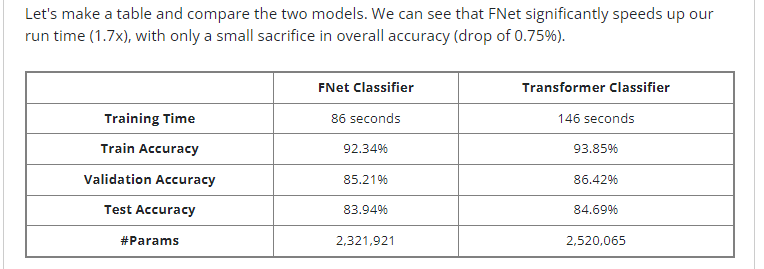

In [28]:
!cp /content/fnet_classifier.keras "/content/drive/MyDrive/Colab Notebooks/ML projects/Tensorflow projects/Tensorflow Developer Certificate/NLP_text_classification_KerasNLP_FNET/"

In [30]:
!cp /content/transformer_classifier.keras "/content/drive/MyDrive/Colab Notebooks/ML projects/Tensorflow projects/Tensorflow Developer Certificate/NLP_text_classification_KerasNLP_FNET/"